In [1]:
import os
import time
from datetime import datetime, timedelta

import gzip
import pickle

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from pylab import rcParams
from scipy.stats import gaussian_kde

import pystan

In [2]:
births_2000s_df = pd.read_csv('US_births_2000-2014_SSA.csv')
births_2000s_df_with_index = births_2000s_df\
    .rename(columns={'date_of_month': 'day'})\
    .set_index(pd.to_datetime(
        births_2000s_df.rename(columns={'date_of_month': 'day'})
        [['year', 'month', 'day']]))\
    .assign(weekday_name=lambda df: df.index.weekday_name)\
    .assign(day_of_year=lambda df: df.index.dayofyear)\
    .assign(week_of_year=lambda df: df.index.weekofyear)
births_2000s_df_with_index.tail()

,year,month,day,day_of_week,births,weekday_name,day_of_year,week_of_year
2014-12-27,2014,12,27,6,8656,Saturday,361,52
2014-12-28,2014,12,28,7,7724,Sunday,362,52
2014-12-29,2014,12,29,1,12811,Monday,363,1
2014-12-30,2014,12,30,2,13634,Tuesday,364,1
2014-12-31,2014,12,31,3,11990,Wednesday,365,1


In [13]:
def get_train_and_test_for_sliding_window(test_date):
    num_data_points_before_first_test_date = datetime(2014, 1, 1) - datetime(2001, 1, 1)
    df = births_2000s_df_with_index[['births']]\
        [lambda df: df.index <= test_date + timedelta(days=6)]\
        [lambda df: df.index >= test_date - num_data_points_before_first_test_date]
    return {
        'train': df[:-7].reset_index().rename({'index': 'ds', 'births': 'y'}, axis = 1),
        'test': df[-7:].reset_index().rename({'index': 'ds', 'births': 'y'}, axis = 1)
    }
        
data = get_train_and_test_for_sliding_window(datetime(2014, 1, 1))

In [15]:
m = Prophet()
m.fit(data['train']);

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\users\ncp\appdata\local\continuum\anaconda3\envs\stan_env\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [27]:
def prophet_fit_separate_sliding_windows(persist_path, num_windows):
    if not os.path.exists(persist_path):
        os.mkdir(persist_path)
    all_prediction_errors = []

    for i in range(num_windows):
        data = get_train_and_test_for_sliding_window(datetime(2014, 1, 1) + timedelta(days=i * 7))

        m = Prophet()
        m.fit(data['train']);
        
        forecast = m.predict(data['test'])
        
        pred_err = forecast['yhat'] - data['test']['y']
        
        all_prediction_errors.append(pred_err)     
        with gzip.open(os.path.join(persist_path, 'fit%d_model.pkl.gz' % i), 'wb') as f:
            pickle.dump(m, f)   
        with gzip.open(os.path.join(persist_path, 'fit%d_pred_err.pkl.gz' % i), 'wb') as f:            
            pickle.dump(pred_err, f)        
        with gzip.open(os.path.join(persist_path, 'fit%d_forecast.pkl.gz' % i), 'wb') as f:
            pickle.dump(forecast, f)   

prophet_fit_separate_sliding_windows(persist_path = 'fit_prophet', num_windows = 52)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\users\ncp\appdata\local\continuum\anaconda3\envs\stan_env\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override 

In [25]:
def rmse(prediction_errors):
    return (prediction_errors ** 2).mean() ** 0.5

In [28]:
def prophet_evaluate_separate_sliding_windows(persist_path, num_windows):
    all_prediction_errors = []
    for i in range(num_windows):
        with gzip.open(os.path.join(persist_path, 'fit%d_pred_err.pkl.gz' % i), 'rb') as f:
            pred_err = pickle.load(f)  
            all_prediction_errors.append(pred_err)
    
    print('RMSE          :', rmse(np.concatenate(all_prediction_errors)))

prophet_evaluate_separate_sliding_windows('fit_prophet', 52)

RMSE          : 722.5853106888579


In [32]:
i = 1
data = get_train_and_test_for_sliding_window(datetime(2014, 1, 1) + timedelta(days=i * 7))

m = Prophet()
m.fit(data['train']);

forecast = m.predict(data['test'])

pred_err = forecast['yhat'] - data['test']['y']

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\users\ncp\appdata\local\continuum\anaconda3\envs\stan_env\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


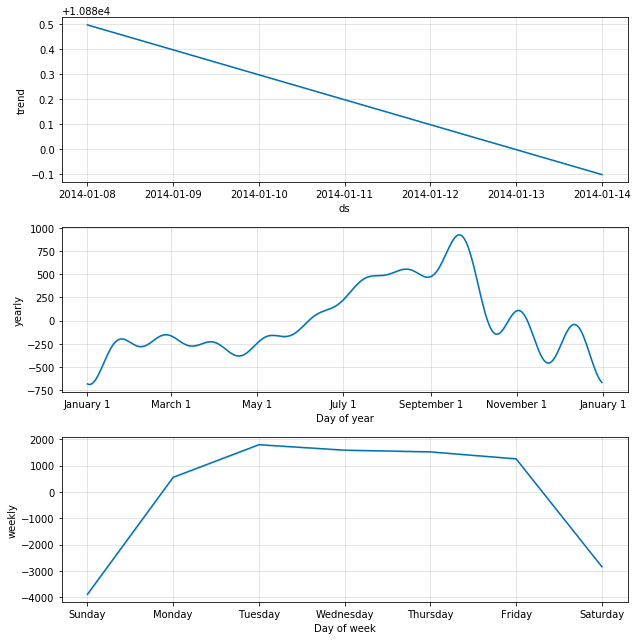

In [36]:
m.plot_components(forecast);
